# Case Study

In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [410]:
#Help funcs for colored output
from termcolor import colored, cprint
def green(txt):
    return colored(txt, 'green')
def red(txt):
    return colored(txt, 'red')
def blue(txt):
    return colored(txt, 'cyan')
def bold(txt):
    return colored(txt, attrs=['bold'])

In [411]:
#Get raw Data
df = pd.read_csv("data/house_data_training.csv", sep=';') 
# remove unnamed column
df = df.iloc[:, 1:]
#Transform string to datetime
df["date"] = pd.to_datetime(df["date"])
df.tail()
#Drop rows with NaN values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14997 non-null  int64         
 1   date           14997 non-null  datetime64[ns]
 2   price          14997 non-null  float64       
 3   bedrooms       14997 non-null  int64         
 4   bathrooms      14997 non-null  float64       
 5   sqft_living    14997 non-null  int64         
 6   sqft_lot       14997 non-null  int64         
 7   floors         14997 non-null  float64       
 8   waterfront     14997 non-null  float64       
 9   dis_super      14997 non-null  float64       
 10  view           14997 non-null  float64       
 11  condition      14997 non-null  float64       
 12  grade          14997 non-null  float64       
 13  sqft_above     14997 non-null  float64       
 14  sqft_basement  14997 non-null  float64       
 15  yr_built       1499

## Modeling

In Task 01_Exploration various qualitative problems within the data were identified. In this chapter different approaches are implemented to solve these problems.

### A) Basic Regression Model
> Creating a basic linear Regression

In [412]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def reg_train_test(X_train, X_test, y_train, y_test):
    '''Function for building Basic Regression Model'''

    # fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # evaluate the model
    ypred = model.predict(X_test)
    
    # evaluate predictions
    mae = mean_absolute_error(y_test, ypred)
    print(f'{bold("Mean Absolute Error")}: {blue(np.round(mae))}\n')
    
    print(f'{bold("Regression coefficients:")} \n{blue(model.coef_)}\n')
    
    print(bold("Prediction Examples:"))
    for i in range(0, 5):
        y_pre= ypred[i]
        print(f'{blue(i)} Actual y: {blue(y_test[i])} Predicted y: {blue(np.round(y_pre))}')
 
    return model

In [428]:
from sklearn.model_selection import train_test_split

# Select price as label
X, y = df, df["price"]
# remove price_data from list
X = X.drop(columns=["price"])

# Transform Column to a numeric value
X[["date"]] = X[["date"]].apply(pd.to_numeric)

# Dataframes in numpy-Arrays konvertieren
X,y  = np.array(X.values.tolist()), np.array(y.values.tolist())

#split Data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
model_0 = reg_train_test(X_train, X_test, y_train, y_test)

Mean Absolute Error: 6328488.0

Regression coefficients: 
[-5.95470171e-05  1.61604290e-12 -1.60811934e+02  1.17008686e+03
 -7.14346768e+01 -6.89727039e+00  9.52661243e+02 -9.78374309e+00
  1.92017246e+02 -2.22214913e+02 -1.21956412e+03  1.05315362e+03
  1.69078816e+02 -4.46440642e+02  1.27618311e+05  6.76627015e+02
  1.92608098e+04 -4.86604442e+01  9.32572756e+01  1.26394714e+02
 -1.19176578e+01  4.31674363e+03 -9.02128076e+01  4.22653083e+03]

Prediction Examples:
0 Actual y: 210000.0 Predicted y: 1787248.0
1 Actual y: 199500.0 Predicted y: -606569.0
2 Actual y: 252700.0 Predicted y: 3916554.0
3 Actual y: 324500.0 Predicted y: 7495947.0
4 Actual y: 265000.0 Predicted y: 1282062.0


### B) Data Preprocessing

> Detect Outliers by building 3 Models


#### Outliers

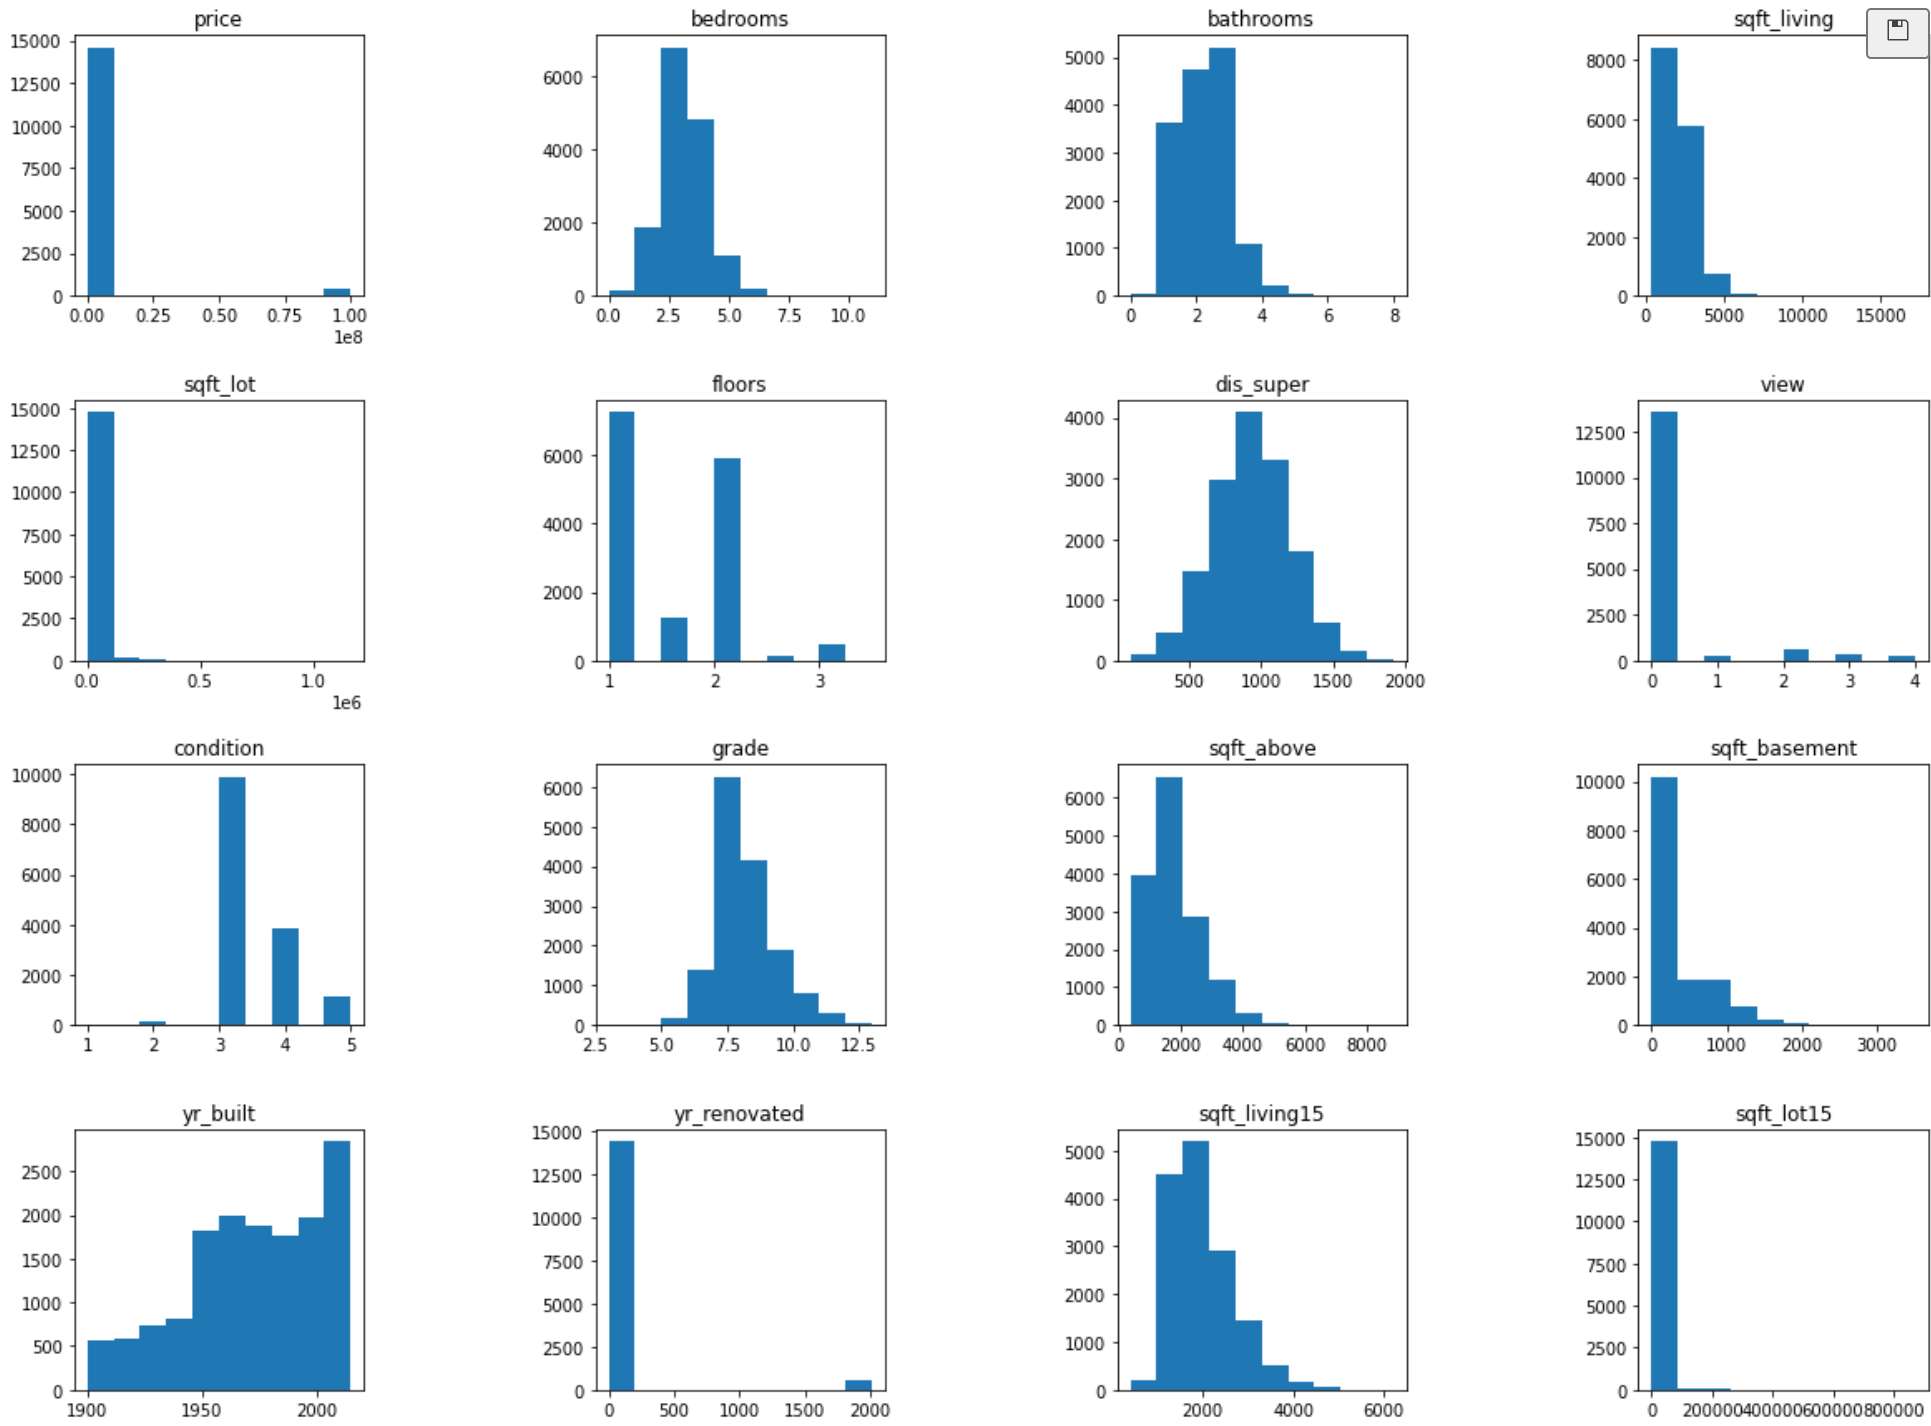

In [414]:
from IPython.display import Image
import os
Image(filename=f'{os.getcwd()}/data/img/outliers_hist.PNG') 

> In this figure we can see the distribution of the values for the different features. Some histograms show a skewed distribution. Sometimes you can immediately recognize Outliers.

##### Method 1: Univariate outlier detection based on descriptive statistics 

In [415]:
#Univariate outlier detection based on descriptive statistics (three standard deviations)
#can be useful to identify extreme outliers

feature_list = df.columns
outliers_dict = {}
outliers_plot_dict = {}
print(bold("Potential Outliers:"))
for feature in feature_list:
    feature_data = df[feature]
    price_data = df["price"]
    # if feature_data.isnumeric():
    if not feature == "price":

        df_feature = pd.concat([feature_data, price_data], axis=1)
        df_feature["outlier"] = 0

        three_std=feature_data.std()*3
        mean=feature_data.mean()

        inlier_low=mean-three_std
        inlier_high=mean+three_std
        #print("mean: ",mean, "lower boundary inlier: ",inlier_low, "upper boundary inlier",inlier_high,"\n")
        outlier_list = []
        for i, value in enumerate(feature_data):
            if value < inlier_low or value > inlier_high:
                outlier_list.append(i)
                df_feature.iloc[i,2] = 1

        print(f'{bold(feature)}: {blue(len(outlier_list))} potential outliers detected')
        if not len(outlier_list) == 0:
            outliers_dict[str(feature)]=outlier_list
            outliers_plot_dict[str(feature)]=df_feature
        #print(type(df_feature), df_feature.head())

#store indexes from the original df of every potential outlier existing in a new df for every column
df_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in outliers_dict.items() ]))
#print(df_outliers.tail())
#print(df_feature.tail())     

Potential Outliers:
id: 0 potential outliers detected
date: 0 potential outliers detected
bedrooms: 50 potential outliers detected
bathrooms: 120 potential outliers detected
sqft_living: 144 potential outliers detected
sqft_lot: 241 potential outliers detected
floors: 6 potential outliers detected
waterfront: 102 potential outliers detected
dis_super: 40 potential outliers detected
view: 559 potential outliers detected
condition: 23 potential outliers detected
grade: 85 potential outliers detected
sqft_above: 169 potential outliers detected
sqft_basement: 168 potential outliers detected
yr_built: 0 potential outliers detected
yr_renovated: 582 potential outliers detected
zipcode: 0 potential outliers detected
lat: 0 potential outliers detected
long: 163 potential outliers detected
sqft_living15: 171 potential outliers detected
sqft_lot15: 242 potential outliers detected
ahf1: 0 potential outliers detected
ahf2: 37 potential outliers detected
ahf3: 1 potential outliers detected


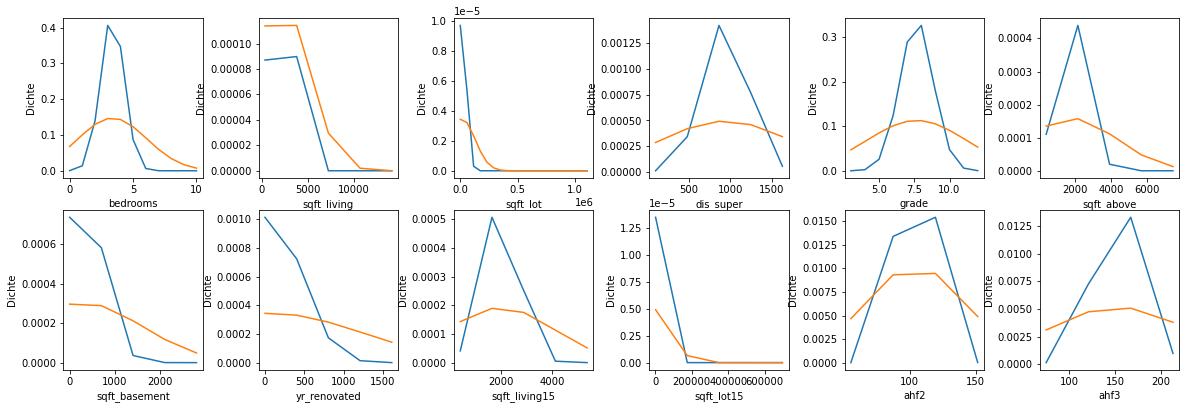

In [416]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm 

fig = plt.figure(figsize=(20,10))
i=1
for key, value in outliers_plot_dict.items():
    plt.subplot(3,6,i)
    data = value[key]
    min = data.min()
    max = data.max()
    if not max <= 10:
        if max >1000000:
            step = np.round(max/20)
        elif max <100:
            step = np.round(max/10)
        elif max >5:
             step = np.round(max/5)    
        #print(max)
        mean = data.mean()
        sd = data.std()
        x_axis = np.arange(min, max, step) 

        fig.subplots_adjust(hspace = .2, wspace=0.4)
        plt.ylabel("Dichte")
        plt.xlabel(key)
        ax = plt.gca()
        #ax.axes.yaxis.set_ticklabels([])
        plt.yticks()
        plt.plot(x_axis, norm.pdf(x_axis, mean, sd)) 
        plt.plot(x_axis, norm.pdf(x_axis, mean, sd*3)) 
        i+=1

plt.show()

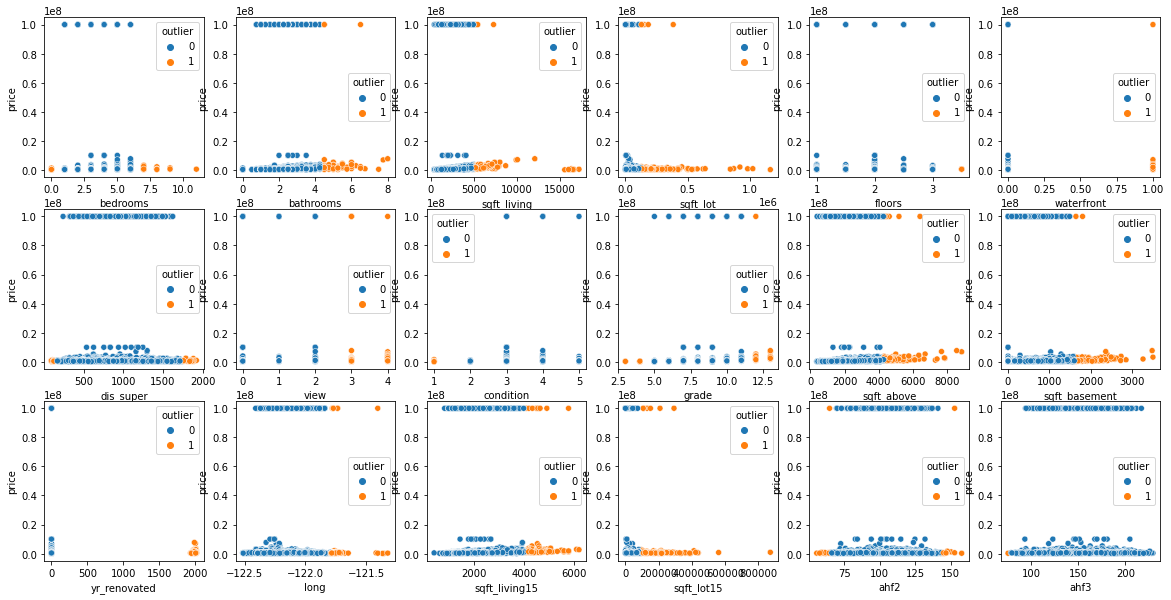

In [418]:
# print(len(outliers_plot_dict))
# fig, ax = plt.subplots(1,len(outliers_plot_dict), figsize=(20,20))
# i=0
# for key, value in outliers_plot_dict.items():
#     print(key)
#     print(value)
#     ax[i].plot(value['price'], value[key], 'o')
#     ax[i].set_xlabel(key)
#     ax[i].set_title('price')   
#     #sns.scatterplot(data=value, x=key, y="price", hue="outlier")
#     i+=1
# plt.show()

fig = plt.figure(figsize=(20,10))
i=1
for key, value in outliers_plot_dict.items():
    plt.subplot(3,6,i)
    sns.scatterplot(data=value, x=key, y="price", hue="outlier")
    i+=1
plt.show()       

##### Method 2: Multivariate outlier detection based on distances

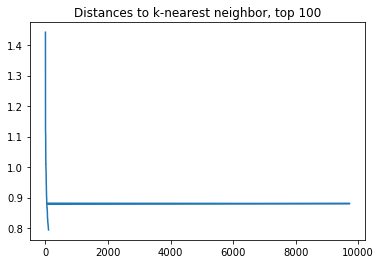

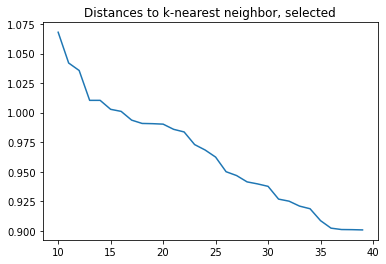

In [427]:
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing

#normalize data to identify outliers
scaler = preprocessing.MinMaxScaler()
X= scaler.fit_transform(X_train)

#determine k nearest neighbors ()
k=3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

#plot Distances to k-nearest neighbor, top 100
plt.title('Distances to k-nearest neighbor, top 100')
top_distance_min=0
top_distance_max=100
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

#plot Distances to k-nearest neighbor, selected
plt.title('Distances to k-nearest neighbor, selected')
top_distance_min=10
top_distance_max=40
plt.plot(indices[top_distance_min:top_distance_max,0],-np.sort(-distances[:,k])[top_distance_min:top_distance_max])
plt.show()

In [426]:
#k= number of outliers // 10% of data 
num_outliers= 250
outlier_indices=np.argpartition(distances[:,1],-num_outliers)[-num_outliers:]
inlier_indices=np.delete(indices[:,0], outlier_indices)

#print("Indices of outliers: ",outlier_indices)
#print("Indices of inliers: ",inlier_indices)
#print("Distances of outliers: ",distances[outlier_indices,1])
#print("Max 10 distances: ",-np.sort(-distances[:,1])[0:10])

# select all rows that are not outliers (inlier=1, outlier=-1)
X_train_red, y_train_red = X_train[inlier_indices, :], y_train[inlier_indices]
# Inliers vs. Outliers
print(bold("Inliers: "),blue(X_train_red.shape[0]),bold("Outliers"),blue(X_train.shape[0]-X_train_red.shape[0]),"\n")
model_02 = reg_train_test(X_train_red ,X_test, y_train_red, y_test)


Inliers:  11747 Outliers 250 

Mean Absolute Error: 6106045.0

Regression coefficients: 
[-1.06428470e-04  5.64819872e-12 -1.68121539e+02  1.09278400e+03
 -1.63955408e+02 -1.53428943e+01  8.91158246e+02 -2.54832375e+00
  6.11966469e+02 -1.77311290e+02 -1.12804975e+03  9.58449524e+02
  2.88082144e+02 -5.31129903e+02  1.18225384e+05  6.04235895e+02
  1.85411905e+04 -4.71827275e+01  8.59638645e+01  1.30436621e+02
 -3.54205659e+00  9.48636389e+03 -4.40565454e+03  5.08070934e+03]

Prediction Examples:
0 Actual y: 210000.0 Predicted y: 2194399.0
1 Actual y: 199500.0 Predicted y: -467535.0
2 Actual y: 252700.0 Predicted y: 3471215.0
3 Actual y: 324500.0 Predicted y: 7253454.0
4 Actual y: 265000.0 Predicted y: 1275524.0


##### Method 3: Multivariate outlier detection based on density (clustering)

In [421]:
from sklearn.cluster import DBSCAN
import pandas as pd

clustering = DBSCAN(eps=0.42, min_samples=5).fit(X)

inliers=[]
outliers=[]
index_upper=distances[:,1].size

for index in range (0,index_upper):
    if clustering.labels_[index] == -1:
        outliers.append([index, distances[index,1]])
    else:
        inliers.append([index, distances[index,1]])

inliers_df=pd.DataFrame(inliers,columns=['index','distance'])
outliers_df=pd.DataFrame(outliers,columns=['index','distance'])

print("inliers: ",inliers_df.describe())
print("\noutliers: ",outliers_df.describe())

inliers:                index     distance
count   9235.000000  9235.000000
mean    5978.306226     0.284525
std     3471.217042     0.089669
min        0.000000     0.000000
25%     2970.500000     0.251202
50%     5975.000000     0.298629
75%     8976.500000     0.341967
max    11996.000000     0.419948

outliers:                index     distance
count   2762.000000  2762.000000
mean    6063.847936     0.470133
std     3436.851613     0.131727
min        4.000000     0.000000
25%     3084.250000     0.421550
50%     6074.000000     0.458359
75%     9071.000000     0.524309
max    11985.000000     1.311730


In [423]:
# select all rows that are not outliers (inlier=1, outlier=-1)
X_train_red, y_train_red = X_train[inliers_df['index'], :], y_train[inliers_df['index']]

# Inliers vs. Outliers
print(bold("Inliers: "),blue(X_train_red.shape[0]),bold("Outliers"),blue(X_train.shape[0]-X_train_red.shape[0]))
model_03 = reg_train_test(X_train_red,X_test,y_train_red, y_test)

Inliers:  9235 Outliers 2762
Mean Absolute Error: 6727487.0

Regression coefficients: 
[-8.68257115e-05 -6.04077990e-12 -2.39646515e+02  1.59440909e+03
 -1.32768235e+02 -3.32825011e+01  1.44413653e+03  1.27329258e-11
  5.74257353e+02 -1.74428777e+00 -1.43570156e+03  1.19521607e+03
  3.19558813e+01 -1.64724116e+02  1.50384377e+05  2.48176173e+03
  2.86720851e+04 -5.94681802e+01  1.09375577e+02  3.27107322e+02
 -2.52301772e+01  5.87486334e+03 -7.62410097e+02  5.11245325e+03]

Prediction Examples:
0 Actual y: 210000.0 Predicted y: 1339704.0
1 Actual y: 199500.0 Predicted y: -1536598.0
2 Actual y: 252700.0 Predicted y: 3711504.0
3 Actual y: 324500.0 Predicted y: 8175237.0
4 Actual y: 265000.0 Predicted y: 484292.0


#### Noise

#### Transformed, standardized or normalized

#### Feature Selection

#### Instance Selection

## Modeling Continued

## Evaluation